# If any issues arise during execution, utilize parallel GPU processing, considering that the model has been trained and saved using parallel GPU architecture.

In [1]:
import os
import cv2
import h5py
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchmetrics
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler, Sampler
from torch.optim import Adam, SGD
from torchvision import transforms, models
from torchvision.models import resnet18  
from torch.utils.data import Dataset
from torchvision.transforms import Resize, ToTensor
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
gpus = torch.cuda.device_count()

if gpus <= 1:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'Using {gpus} GPU')
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using {gpus} GPUs')


Using 2 GPUs


In [3]:
MIX = False
if MIX:
    scaler = GradScaler()
    print('Mixed precision enabled')
else:
    print('Using full precision')

Using full precision


In [4]:
dfs = []
parquet_file = pq.ParquetFile('/kaggle/input/task-3a/Task_3a/top_gun_opendata_3.parquet')
total_rows = parquet_file.metadata.num_rows
chunk_size = 8
for i in range(0,total_rows,chunk_size):
    chunk = parquet_file.read_row_group(i)
    df = chunk.to_pandas()
    condition = (df['m'] > 0) & (df['m'] < 256) & (df['pt'] > 320) & (df['pt'] < 1600) & (df['ieta'] < 80.25)
    filtered_df = df[condition]
    if not filtered_df.empty:
        dfs.append(filtered_df)

dataset = pd.concat(dfs, ignore_index=True)
print('Dataset Length:', len(dataset))

Dataset Length: 7676


In [5]:
dataset.describe()

,m,iphi,pt,ieta
count,7676.000000,7676.000000,7676.000000,7676.000000
mean,170.188106,35.123372,699.564382,27.449844
std,49.473223,20.743823,173.854311,8.596656
min,85.339424,0.000000,400.474030,12.000000
25%,127.098766,17.000000,547.183167,20.000000
50%,171.119751,35.000000,701.326172,27.000000
75%,213.003334,53.000000,850.035019,35.000000
max,255.973297,71.000000,999.966858,43.000000


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7676 entries, 0 to 7675
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X_jet   7676 non-null   object 
 1   m       7676 non-null   float64
 2   iphi    7676 non-null   float64
 3   pt      7676 non-null   float64
 4   ieta    7676 non-null   float64
dtypes: float64(4), object(1)
memory usage: 300.0+ KB


In [7]:
total_r = dataset["X_jet"].shape[0]
total_r

7676

In [8]:
dataset["X_jet"][0].shape

(8,)

In [9]:
dataset["X_jet"][0][0].shape

(125,)

In [10]:
dataset["X_jet"][0][0][0].shape

(125,)

In [11]:
def to_array(data):
    arr = []
    for i in range(0, 4):
        a = np.stack(np.stack(data)[i], axis=-1)
        arr.append(a)
    arr = np.array(arr)
    arr = arr.reshape((125, 125, 4))
    return arr

In [12]:
dataset["X_jet"] = dataset["X_jet"].apply(to_array)


In [13]:
dataset["X_jet"][0].shape

(125, 125, 4)

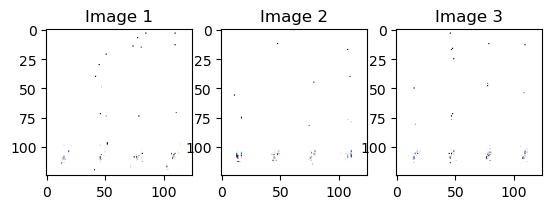

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3)
for i, ax in enumerate(axes.flatten()):
    image = dataset['X_jet'][i][:,:,:]
    ax.imshow(image)
    ax.set_title(f'Image {i+1}')

plt.show()

In [15]:
train_df, val_df = train_test_split(dataset, test_size=0.2, random_state=42)

In [16]:
class CFG:
    model_name = 'resnet18'
    batch_size = 64
    learning_rate = 5e-4
    num_epochs = 25
    random_state = 42
    num_class=3
    weight_decay = 1e-2

In [19]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CustomResNet18(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomResNet18, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.in_planes = 64  

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)

        self.fc1 = nn.Linear(256 * 16 * 16, 512) 
        self.fc2 = nn.Linear(512, 256)
        
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion  
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

       
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x.squeeze()

In [28]:
model = CustomResNet18().to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-7)

In [17]:
X_jets = np.stack(train_df['X_jet'].apply(np.concatenate).values)
X_train = torch.tensor(X_jets, dtype=torch.float32).view(-1, 125,125, 4)
y_train = pd.to_numeric(train_df['m'])
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_jets = np.stack(val_df['X_jet'].apply(np.concatenate).values)
X_val = torch.tensor(X_jets, dtype=torch.float32).view(-1,125, 125, 4)

y_val = pd.to_numeric(val_df['m'])
y_val = torch.tensor(y_val.values, dtype=torch.float32)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=True)

In [18]:
next(iter(train_loader))[0].shape

torch.Size([64, 125, 125, 4])

In [29]:
train_losses = []
val_losses = []
mae_losses = []
mre_losses = []

best_val_loss = float('inf')
best_mre = float('inf')
best_val_loss_model = None
best_mre_model = None

for epoch in range(CFG.num_epochs):
    model.train()
    train_loss = 0.0
    train_preds_list = []

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{CFG.num_epochs} (Training)'):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 3, 1, 2)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds_list.append(outputs.detach().cpu().numpy())

    train_loss /= len(train_loader)
    train_preds = np.concatenate(train_preds_list)

    model.eval()
    val_loss = 0.0
    mae_loss = 0.0
    mre_loss = 0.0
    val_preds_list = []

    for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{CFG.num_epochs} (Validation)'):
        inputs = inputs.permute(0, 3, 1, 2)
        val_inputs, val_labels = inputs.to(device), labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += criterion(val_outputs, val_labels).item()
        val_preds_list.append(val_outputs.detach().cpu().numpy())
        mae_loss += torch.abs(val_outputs - val_labels).sum().item()
        absolute_errors = torch.abs(val_outputs - val_labels)
        mre_loss += (absolute_errors / (torch.abs(val_labels) + 1e-6)).sum().item()

    val_loss /= len(val_loader)
    mae_loss /= len(val_loader.dataset)
    mre_loss /= len(val_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    mae_losses.append(mae_loss)
    mre_losses.append(mre_loss)
    
    scheduler.step(val_loss)  
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_loss_model = model.state_dict()

    if mre_loss < best_mre:
        best_mre = mre_loss
        best_mre_model = model.state_dict()
    
    print(f"Epoch {epoch + 1}/{CFG.num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, MAE: {mae_loss:.4f}, MRE: {mre_loss:.4f}")
    
torch.save(best_val_loss_model, 'best_model_val_loss.pth')
torch.save(best_mre_model, 'best_model_mre.pth')
print("Model saved successfully.")
print("Finished training")

Epoch 1/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.00it/s]


Epoch 1/25, Train Loss: 3300.9318, Val Loss: 3230.2537, MAE: 45.2589, MRE: 0.2426


Epoch 2/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.49it/s]


Epoch 2/25, Train Loss: 1596.4099, Val Loss: 1705.8297, MAE: 33.2397, MRE: 0.2200


Epoch 3/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.72it/s]


Epoch 3/25, Train Loss: 1701.8970, Val Loss: 2590.7840, MAE: 41.5526, MRE: 0.2329


Epoch 4/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.47it/s]


Epoch 4/25, Train Loss: 1483.4979, Val Loss: 2382.0626, MAE: 39.1578, MRE: 0.2162


Epoch 5/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.28it/s]


Epoch 5/25, Train Loss: 1283.6276, Val Loss: 1883.8958, MAE: 36.8603, MRE: 0.2470


Epoch 6/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.67it/s]


Epoch 6/25, Train Loss: 1246.5962, Val Loss: 2035.6667, MAE: 37.4334, MRE: 0.2779


Epoch 7/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.49it/s]


Epoch 7/25, Train Loss: 1272.6192, Val Loss: 1601.5916, MAE: 31.5284, MRE: 0.1889


Epoch 8/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.42it/s]


Epoch 8/25, Train Loss: 1378.0446, Val Loss: 1892.3246, MAE: 33.5157, MRE: 0.1946


Epoch 9/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.42it/s]


Epoch 9/25, Train Loss: 1290.3300, Val Loss: 2129.8490, MAE: 37.1987, MRE: 0.2111


Epoch 10/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.72it/s]


Epoch 10/25, Train Loss: 987.4350, Val Loss: 1460.1281, MAE: 30.0755, MRE: 0.1915


Epoch 11/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.29it/s]


Epoch 11/25, Train Loss: 1090.9267, Val Loss: 2658.6888, MAE: 40.3265, MRE: 0.2229


Epoch 12/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.46it/s]


Epoch 12/25, Train Loss: 1099.9215, Val Loss: 1706.3840, MAE: 33.5807, MRE: 0.2220


Epoch 13/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.48it/s]


Epoch 13/25, Train Loss: 1018.9483, Val Loss: 2298.1543, MAE: 37.2479, MRE: 0.2101


Epoch 14/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.30it/s]


Epoch 14/25, Train Loss: 1007.5593, Val Loss: 2123.8071, MAE: 36.7511, MRE: 0.2124


Epoch 15/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.24it/s]


Epoch 15/25, Train Loss: 720.3168, Val Loss: 1673.3811, MAE: 33.3198, MRE: 0.2286


Epoch 16/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.65it/s]


Epoch 16/25, Train Loss: 659.0815, Val Loss: 1775.1558, MAE: 34.4729, MRE: 0.2432


Epoch 17/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.24it/s]


Epoch 17/25, Train Loss: 640.4506, Val Loss: 1567.9298, MAE: 31.7118, MRE: 0.2103


Epoch 18/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.45it/s]


Epoch 18/25, Train Loss: 565.1042, Val Loss: 1773.8687, MAE: 34.2183, MRE: 0.2196


Epoch 19/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.60it/s]


Epoch 19/25, Train Loss: 444.1426, Val Loss: 1630.4689, MAE: 31.8670, MRE: 0.2115


Epoch 20/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.51it/s]


Epoch 20/25, Train Loss: 430.4030, Val Loss: 1679.9128, MAE: 31.6388, MRE: 0.2015


Epoch 21/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.46it/s]


Epoch 21/25, Train Loss: 370.7926, Val Loss: 1812.3531, MAE: 34.5830, MRE: 0.2345


Epoch 22/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.49it/s]


Epoch 22/25, Train Loss: 578.7951, Val Loss: 3169.2594, MAE: 45.3073, MRE: 0.3397


Epoch 23/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.88it/s]


Epoch 23/25, Train Loss: 299.3901, Val Loss: 1831.7659, MAE: 33.5539, MRE: 0.2247


Epoch 24/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.48it/s]


Epoch 24/25, Train Loss: 228.0465, Val Loss: 2090.6986, MAE: 35.7831, MRE: 0.2110


Epoch 25/25 (Validation): 100%|██████████| 24/24 [00:01<00:00, 16.14it/s]


Epoch 25/25, Train Loss: 531.9921, Val Loss: 2683.1321, MAE: 40.2438, MRE: 0.2275
Model saved successfully.
Finished training


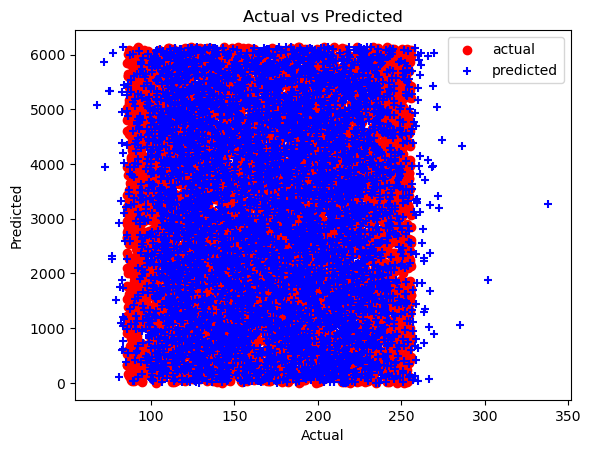

In [57]:
checkpoint = torch.load("/kaggle/working/best_model_val_loss.pth")
model = CustomResNet18()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.load_state_dict(checkpoint)
model = model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        output = model(data)
        y_true.extend(target.cpu().numpy().tolist())
        y_pred.extend(output.cpu().numpy().tolist())

plt.scatter(y_true, range(len(train_dataset)), color='red', label='actual')
plt.scatter(y_pred, range(len(train_dataset)), color='blue', marker='+', label="predicted")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


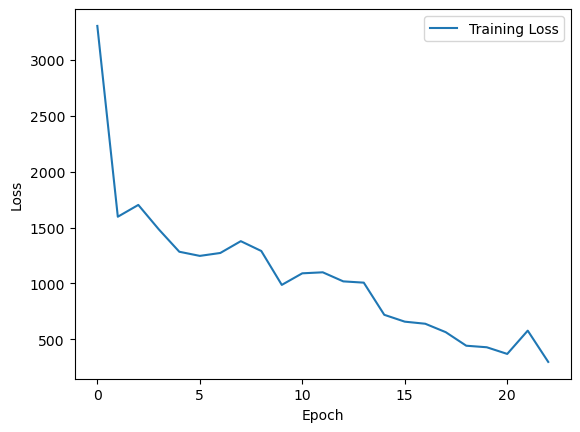

In [36]:
plt.plot( train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
criterion(torch.tensor(y_pred),torch.tensor(y_true))

tensor(263.3684)

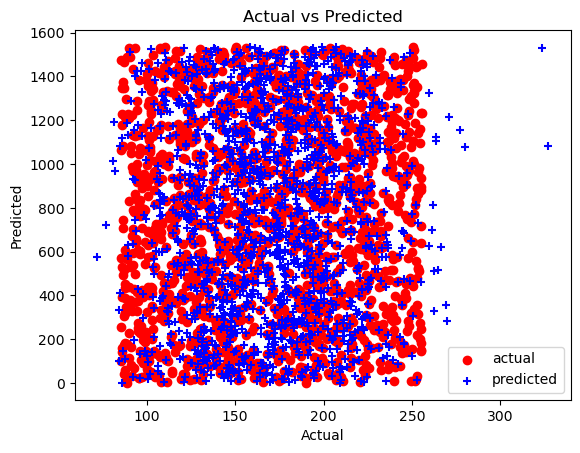

Average loss: 1729.8170878092449


In [53]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        output = model(data)
        
        y_true.extend(target.cpu().numpy().tolist())
        y_pred.extend(output.cpu().numpy().tolist())

plt.scatter(y_true, range(len(val_dataset)), color='red', label='actual')
plt.scatter(y_pred, range(len(val_dataset)), color='blue', marker='+', label="predicted")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()
